# GRU_FC
# This script is for multilayer/stacked Version-8 LSTM-RNN-GRU






In [1]:
########################### 
# defining the Neural Network parameters
country='US'
eps=20
# do not have to change these values
hidden_size=300 #[20, 50, 100, 150, 200, 250, 300]
num_layers=2 #[1 2 3 4 5]
lr=0.00001 #[0.1, 0.01, 0.001, 0.0001, 0.00001]
window_size = 30
real_future = 60
input_size=1 
output_size=1
########################### 

In [2]:
# importing libraries, warnings and models
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')
print('cuda' if torch.cuda.is_available() else cpu) 

cuda


In [3]:
# loading the data and data preprocessing
file_name='time_series_covid19_confirmed_global.csv'
data = pd.read_csv(file_name)
data = data.drop(['Province/State','Lat','Long'], axis = 1)
data = data[data['Country/Region'] == country]
data = pd.DataFrame(data = data.T)
data['total']=data.sum(axis=1)
day_date=pd.to_datetime(data.index[1:])
y_org=data[data.columns[1]][1:].values.astype(float)
x=np.arange(0,len(y_org))
# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
y = scaler.fit_transform(y_org.reshape(-1, 1))
y_org

array([1.000000e+00, 1.000000e+00, 2.000000e+00, 2.000000e+00,
       5.000000e+00, 5.000000e+00, 5.000000e+00, 5.000000e+00,
       5.000000e+00, 7.000000e+00, 8.000000e+00, 8.000000e+00,
       1.100000e+01, 1.100000e+01, 1.100000e+01, 1.100000e+01,
       1.100000e+01, 1.100000e+01, 1.100000e+01, 1.100000e+01,
       1.200000e+01, 1.200000e+01, 1.300000e+01, 1.300000e+01,
       1.300000e+01, 1.300000e+01, 1.300000e+01, 1.300000e+01,
       1.300000e+01, 1.300000e+01, 1.500000e+01, 1.500000e+01,
       1.500000e+01, 1.500000e+01, 1.500000e+01, 1.500000e+01,
       1.600000e+01, 1.600000e+01, 2.400000e+01, 3.000000e+01,
       5.300000e+01, 7.300000e+01, 1.040000e+02, 1.740000e+02,
       2.220000e+02, 3.370000e+02, 4.510000e+02, 5.190000e+02,
       7.110000e+02, 1.109000e+03, 1.561000e+03, 2.157000e+03,
       2.870000e+03, 2.968000e+03, 4.360000e+03, 6.141000e+03,
       8.917000e+03, 1.415700e+04, 1.947900e+04, 2.582500e+04,
       3.376100e+04, 4.385000e+04, 5.411200e+04, 6.6055

In [4]:
# Define a test size, create train and test sets
test_size = 14
train_set = y[:-test_size]
test_set = y[-test_size:]
train_set_x = x[:-test_size]
test_set_x = x[-test_size:]

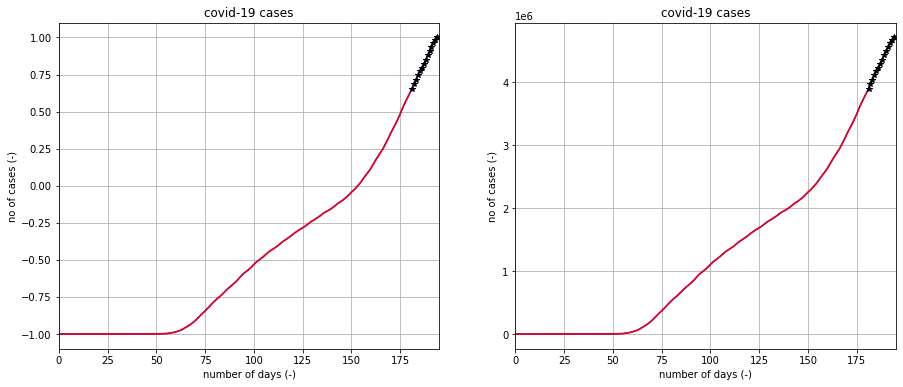

In [5]:
# data visualization to check the outliers
fig = plt.figure(figsize=(15,6))
plt.subplot(122)
plt.subplot(1,2,1)
#plt.figure(figsize=(12,4))
plt.title('covid-19 cases')
plt.ylabel('no of cases (-)')
plt.xlabel('number of days (-)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xlim(0,len(y_org))
plt.plot(x,y,'-b')
plt.plot(train_set_x, train_set, 'r')
plt.plot(test_set_x,test_set, '*k')
#################################################################
plt.subplot(1,2,2)
#plt.figure(figsize=(6,6))
plt.title('covid-19 cases')
plt.ylabel('no of cases (-)')
plt.xlabel('number of days (-)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xlim(0,len(y_org))
y_total=scaler.inverse_transform(y)
plt.plot(x,y_total,'-b')
train_set_y=scaler.inverse_transform(train_set)                         
plt.plot(train_set_x, train_set_y, 'r')
test_set_y=scaler.inverse_transform(test_set)
plt.plot(test_set_x,test_set_y, '*k')
warnings.filterwarnings(action='once')

In [6]:
# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Multilayer GRU

In [7]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Add an GRU layer:
        self.GRU = nn.GRU(self.input_size,self.hidden_size,self.num_layers)
        #Add a fully-connected layer:
        self.linear = nn.Linear(self.hidden_size, output_size)
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(self.num_layers,1,self.hidden_size).cuda(),
                       torch.zeros(self.num_layers,1,self.hidden_size).cuda())
    def forward(self, seq):
        gru_out, self.hidden = self.GRU(seq.view(len(seq), 1,-1))
        pred = self.linear(gru_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [8]:
# implementing Adam optimizer
torch.manual_seed(101)
model = GRU(input_size, hidden_size, output_size, num_layers).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)
#optimizer = torch.optim.SGD(model.parameters(), lr)
model

GRU(
  (GRU): GRU(1, 300, num_layers=2)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)

In [9]:
#function to claculate the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(model)

   900
270000
   900
   900
270000
270000
   900
   900
   300
     1
______
814801


# Simultaneous training on the total data and forecasting the future trends


Epoch:  1 Loss: 0.92108905


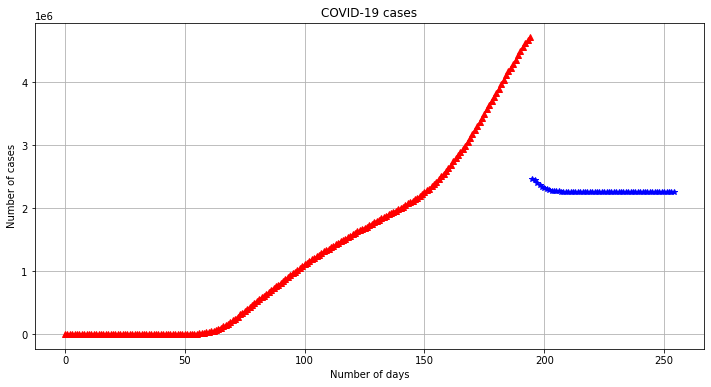

Epoch:  2 Loss: 0.75322509


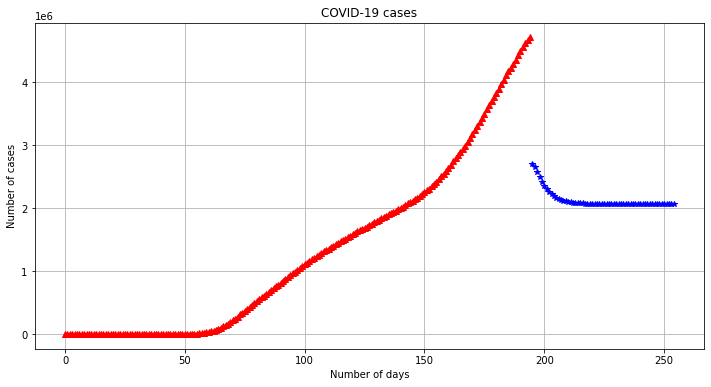

Epoch:  3 Loss: 0.39543477


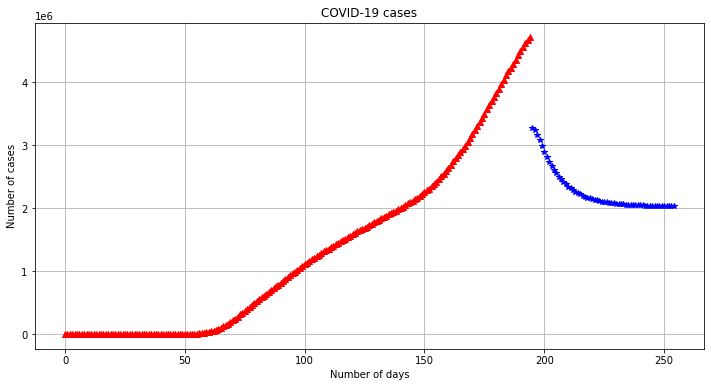

Epoch:  4 Loss: 0.10817230


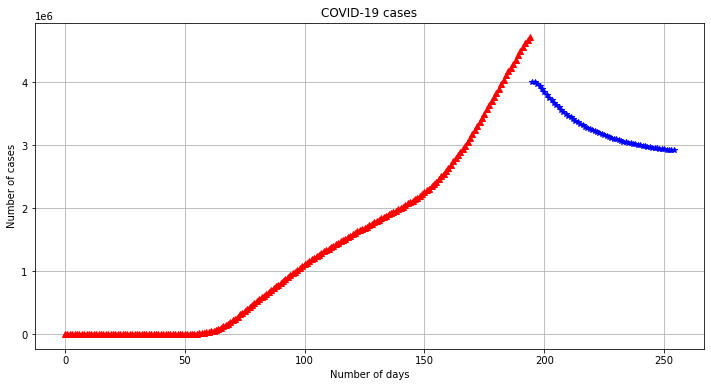

Epoch:  5 Loss: 0.00847895


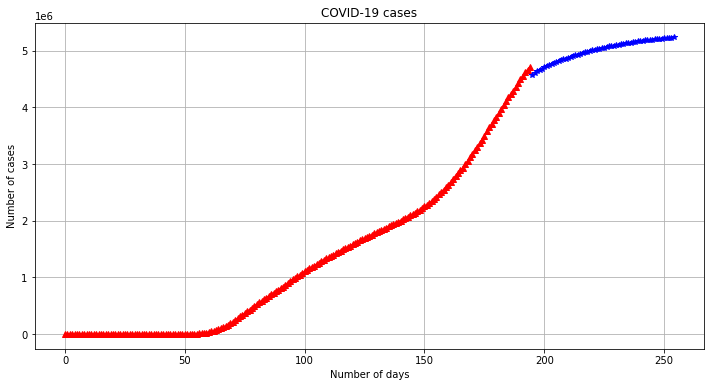

Epoch:  6 Loss: 0.00000034


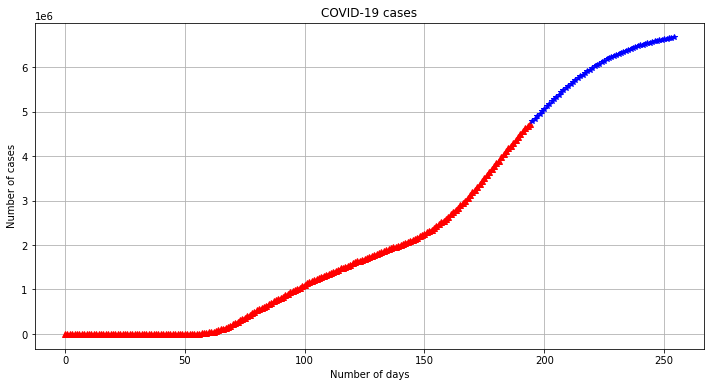

Epoch:  7 Loss: 0.00018040


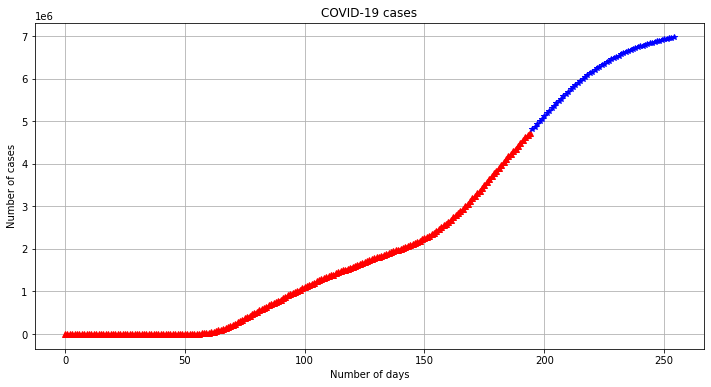

Epoch:  8 Loss: 0.00048966


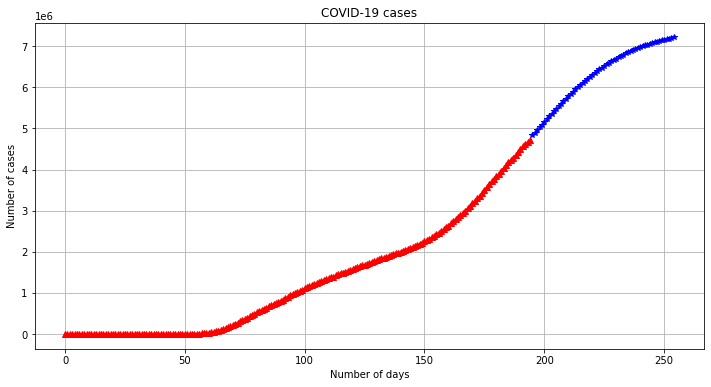

Epoch:  9 Loss: 0.00087998


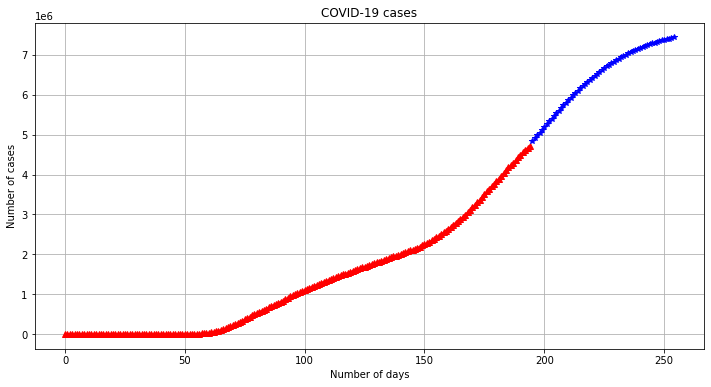

Epoch: 10 Loss: 0.00126279


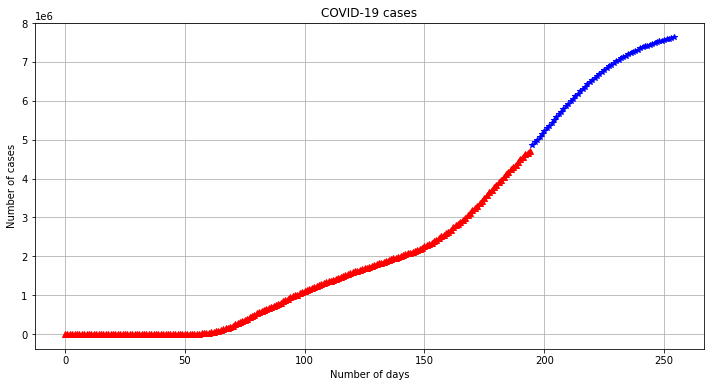

Epoch: 11 Loss: 0.00159921


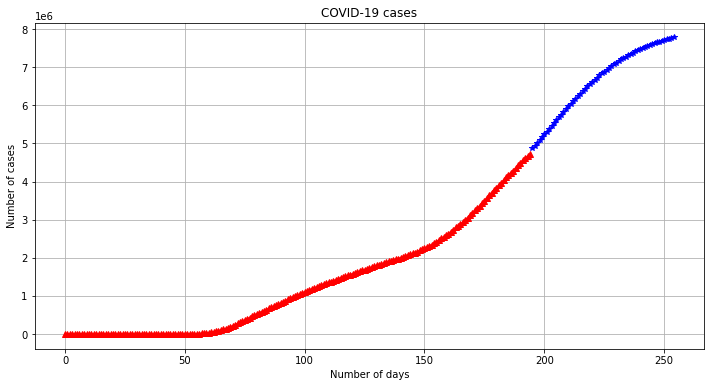

Epoch: 12 Loss: 0.00185651


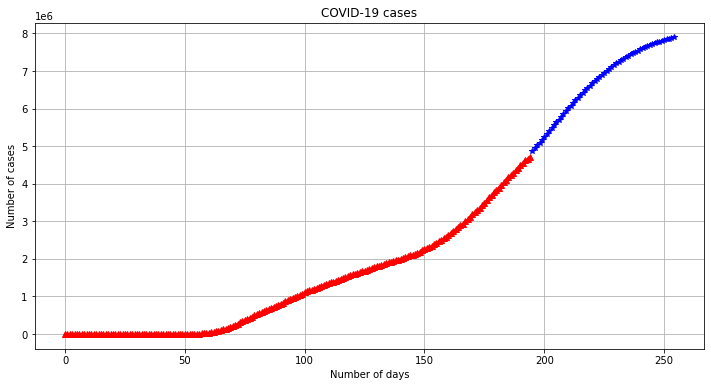

Epoch: 13 Loss: 0.00202472


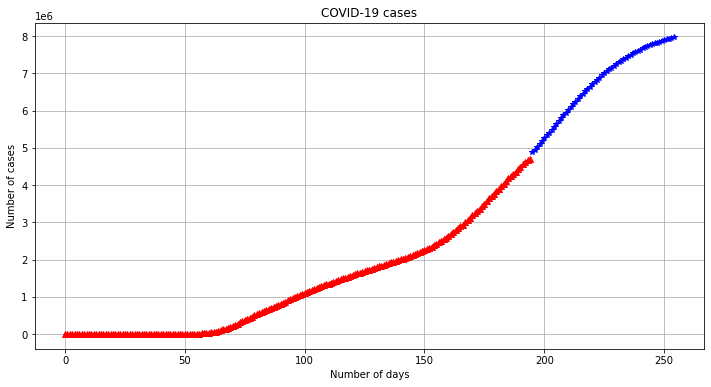

Epoch: 14 Loss: 0.00210462


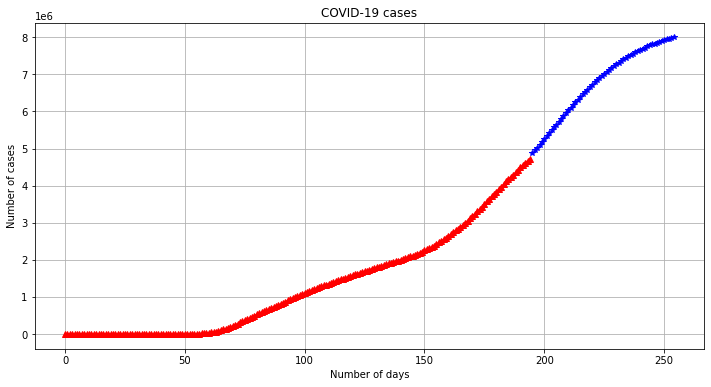

Epoch: 15 Loss: 0.00210690


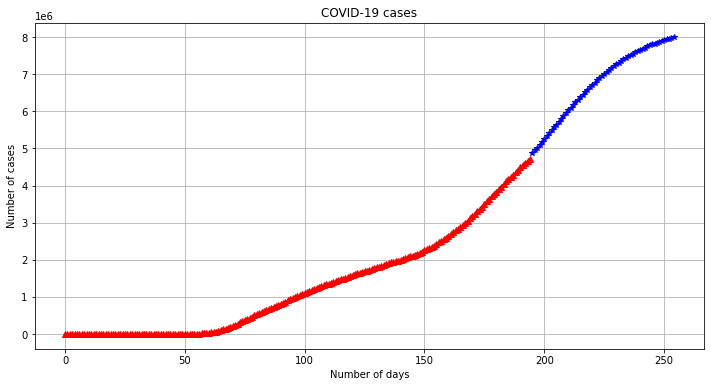

Epoch: 16 Loss: 0.00204583


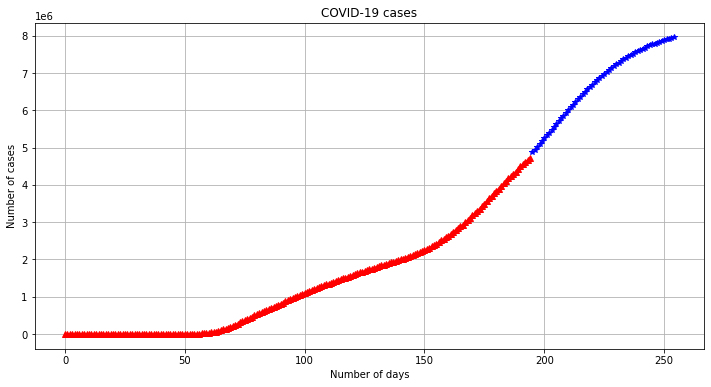

Epoch: 17 Loss: 0.00193679


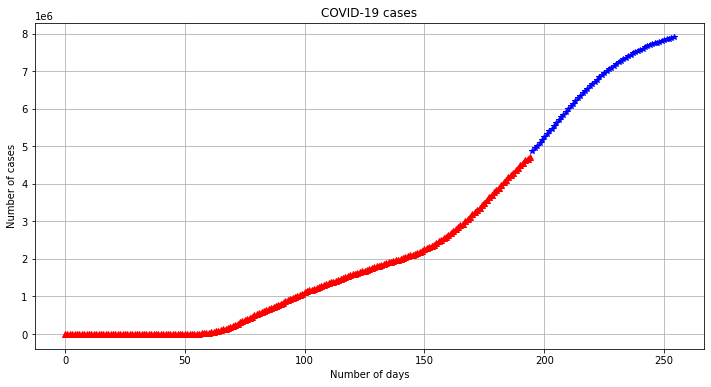

Epoch: 18 Loss: 0.00179395


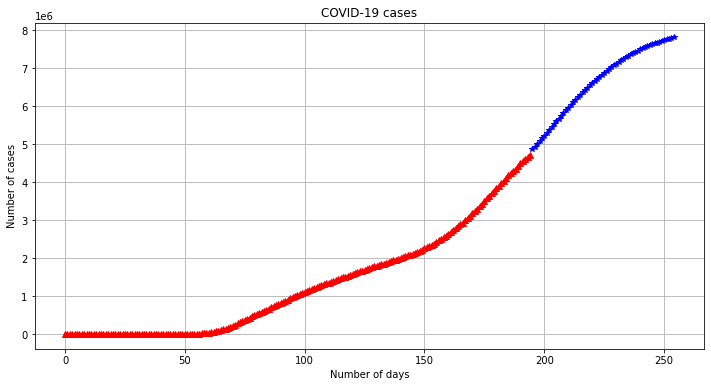

Epoch: 19 Loss: 0.00162956


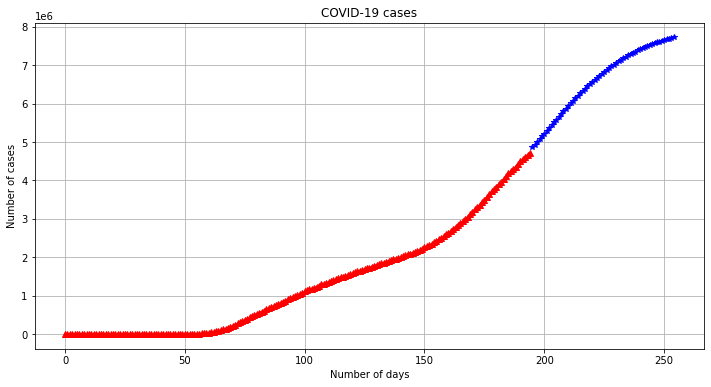

Epoch: 20 Loss: 0.00145375


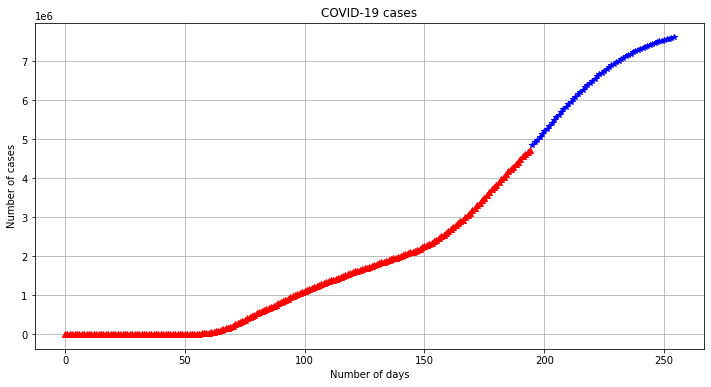


Duration: 25 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


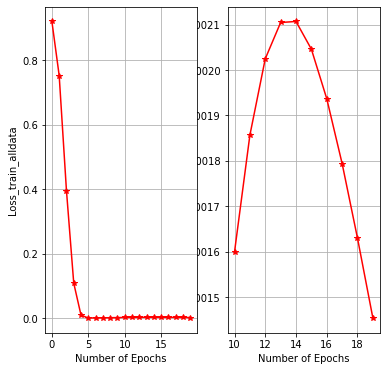

In [10]:
epochs_future = eps
# Define a window size (defined with model parameters)
start_time = time.time()
loss_train_alld=[]
y = torch.FloatTensor(y).view(-1).cuda()
all_data = input_data(y,window_size)
for epoch in range(epochs_future):
    # extract the sequence & label from the training data
    for seq, y_train in all_data:
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(model.num_layers,1,model.hidden_size).cuda(),
                        torch.zeros(model.num_layers,1,model.hidden_size).cuda())
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    loss_train_alld.append(loss.item())    
    # Add the last window of training values to the list of predictions
    preds = y[-window_size:].tolist()
    for i in range(real_future):
        seq = torch.FloatTensor(preds[-window_size:]).cuda()
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers,1,model.hidden_size).cuda(),
                            torch.zeros(model.num_layers,1,model.hidden_size).cuda())
            preds.append(model(seq).item())    
    future_predictions = scaler.inverse_transform(np.array(preds[-real_future:]).reshape(-1, 1))
    # print training result
    # Plot the end of the graph
    fig3 = plt.figure(figsize=(12,6))
    plt.title('COVID-19 cases')
    plt.ylabel('Number of cases')
    plt.xlabel('Number of days')
    plt.grid(True)
    # Select the end of the graph with slice notation:
    plt.plot(y_org, '-^r')
    plt.plot(np.arange(len(y_org), len(y_org)+real_future),future_predictions, '*b')
    plt.show()
fig_name3='GRU_FP_ep'+str(eps)+'_hs_'+str(hidden_size)+'_nl_'+str(num_layers)+'_lr_'+str(lr)+'_ws_'+str(window_size)+'.png'
fig3.savefig(fig_name3, bbox_inches='tight')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')
fig4 = plt.figure(figsize=(6,6))
plt.subplot(122)
plt.subplot(121)
plt.plot(np.arange(epochs_future),(loss_train_alld),'*-r')
plt.grid (True)
plt.ylabel('Loss_train_alldata')
plt.xlabel('Number of Epochs')
plt.subplot(122)
plt.plot(np.arange(10,epochs_future),(loss_train_alld[10:]),'*-r')
plt.grid (True)
plt.ylabel('Loss_train_alldata')
plt.xlabel('Number of Epochs')
warnings.filterwarnings(action='once')
fig_name4='GRU_FPloss_ep'+str(eps)+'_hs_'+str(hidden_size)+'_nl_'+str(num_layers)+'_lr_'+str(lr)+'_ws_'+str(window_size)+'.png'
fig4.savefig(fig_name4, bbox_inches='tight')
w1=day_date
w2=y_org
w3=np.arange(len(y_org), len(y_org)+real_future)
w4=future_predictions.ravel() 
w5=np.arange(epochs_future).T
w6=(loss_train_alld)
data2save2=pd.DataFrame(data=[w1,w2,w3,w4,w5,w6])
data2save2=data2save2.T
data2save2.columns = ['date_org','reported_data','fp_Numx', 'fp_cases', 'epchs_fp', 'loss_train_alldata']
data2save2.to_csv(country+'_gru_forecast'+file_name[20:-4]+fig_name4[1:-4]+'.csv', index=0)